In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

In [2]:
Nx = 101
x_total_arr = np.linspace(0, 10.0, 1+Nx+1)
x_arr = x_total_arr[1:-1]
Vx = np.full_like(x_arr, 0.0, dtype=float)
dx = x_arr[1] - x_arr[0]

In [3]:
from tdse.propagator.box1d import Time_Indep_Hamil_Propagator
prop = Time_Indep_Hamil_Propagator(Nx, dx, Vx)

# Compare the ground state with analytical solution

In [4]:
sf_arr = np.empty((Nx,), dtype=complex)
sf_arr[:] = np.random.rand(Nx)

prop.propagate_to_ground_state(sf_arr)

iteration count at end: 158


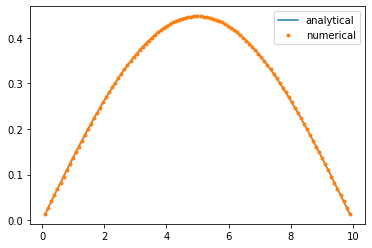

In [5]:
fig, ax = plt.subplots()
lana, = ax.plot(x_arr, np.sqrt(2./10.0)*np.sin(pi/10.0*x_arr))
lnum, = ax.plot(x_arr, sf_arr.real, '.')
ax.plot(x_arr, np.abs(sf_arr), color=lnum.get_color())
ax.legend([lana, lnum], ['analytical', 'numerical'])

# Animate propagation

In [6]:
from matplotlib.animation import FuncAnimation

%matplotlib notebook

In [7]:
t0 = 0.0
sf_t0_arr = np.sin(pi/10.0*x_arr) + 0.6*np.sin(2*pi/10.0*x_arr)
prop.wf.normalize(sf_t0_arr, dx)

<IPython.core.display.Javascript object>


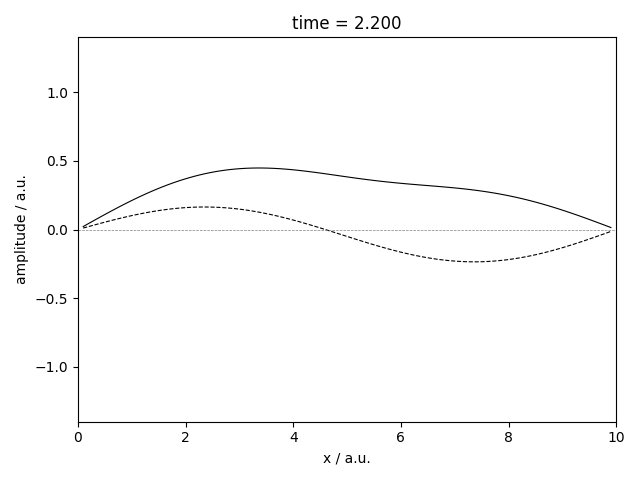

In [8]:
fig, ax = plt.subplots()

ax.set_xlim(x_total_arr[[0,-1]]), ax.set_ylim(-1.4,1.4)
ax.set_xlabel("x / a.u."), ax.set_ylabel("amplitude / a.u.")
title_form = "time = {:.3f}"
ax.set_title(title_form)

l, = ax.plot([],[],'--',linewidth=0.8,color='black')
l_env, = ax.plot([],[],linewidth=0.8,color=l.get_color())
ax.plot(ax.get_xlim(), [0,0], '--',linewidth=0.5, color='gray')

fig.tight_layout()

dt = 0.1
sf_arr = np.empty_like(x_arr, dtype=complex)

def init():
    sf_arr[:] = sf_t0_arr

def update(i):
    ax.set_title(title_form.format(t0+i*dt))
    prop.propagate(sf_arr, dt, Nt=15)
    l.set_data(x_arr, sf_arr.real)
    l_env.set_data(x_arr, np.abs(sf_arr))

ani = FuncAnimation(fig, update, frames=30, init_func=init)

In [9]:
from matplotlib.animation import PillowWriter
# ani.save("ani-test-3.gif", writer=PillowWriter(fps=5))